# ROMS model data

DOPPIO is a regional model (ROMS) run at rutgers by John Wilkin's group to forecast the state of the Gulf of Maine / mid atlantic bight. 


The data is available on a thredds server:

http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best

## working with grids
This notebook is my attempt to learn about the ROMS grid and how to make plots. More below info below. 

![](https://xgcm.readthedocs.io/en/latest/_images/grid2d_hv.svg)

image from xgcm / pycomodo

# Grids

ROMS uses a C-grid, common for ocean models, which means the the velocities, and scalars are actually on a different grid (**note:** actually this doppio output has `v_northward` and `u_eastward` on the center grid, but more generally this isn't true). In addition its vertical coordinate is not depth. These grid things really matter if we want to make plots of velocity, vertical slices, or calculate anything about our grid. 

I'm not *at all* an expert in modeling or these grids. I'm just interested in trying to make some simple plots. I've been looking at these resources to try to understand how to work with the ROMS grid in python:

xarray example: http://xarray.pydata.org/en/scipy19-docs/examples/ROMS_ocean_model.html

discussion on xgcm: https://github.com/xgcm/xgcm/issues/108

xgcm in general: https://xgcm.readthedocs.io/en/latest/index.html

I think in combo these sources are really helpful. I'm going to try to puzzle through working with the grid useing these ideas. 


In [1]:
import xarray as xr
import matplotlib.pyplot as plt

import seawater as sw
import numpy as np

import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

/Users/beaird/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# read in the data

available at:
```python
url = 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best'
```


I'm only grabbing a single day for now while I play with things

In [4]:
url = 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best'

ds = xr.open_dataset(url).sel(time = '2019-07-21', method = 'nearest').squeeze()

ds

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 105, eta_rho: 106, eta_u: 106, eta_v: 105, s_rho: 40, s_w: 41, tracer: 2, xi_psi: 241, xi_rho: 242, xi_u: 241, xi_v: 242)
Coordinates:
  * s_rho           (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
  * s_w             (s_w) float64 -1.0 -0.975 -0.95 -0.925 ... -0.05 -0.025 0.0
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
    ocean_time      datetime64[ns] 2019-10-02T12:00:00
    time            datetime64[ns] 2019-07-21T12:00:00
    time_run        datetime64[ns] ...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Dat

# first, get a depth grid from s_rho:
following xarray example: http://xarray.pydata.org/en/scipy19-docs/examples/ROMS_ocean_model.html

If we want to plot anything vs depth we need to convert from `s_rho` to depth

$Z_0 = (h_c \, S + h \,C) / (h_c + h)$

$z = Z_0 (\zeta + h) + \zeta$


This transformation takes a while. Probably need to subset the data first so you don't do it on everything.

In [5]:

if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho

ds.coords['z_rho'] = z_rho.transpose()   
ds.salt

<xarray.DataArray 'salt' (s_rho: 40, eta_rho: 106, xi_rho: 242)>
[1026080 values with dtype=float64]
Coordinates:
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    lon_rho     (eta_rho, xi_rho) float64 -75.19 -75.13 -75.08 ... -64.62 -64.54
    lat_rho     (eta_rho, xi_rho) float64 32.24 32.28 32.32 ... 46.58 46.61
    ocean_time  datetime64[ns] 2019-10-02T12:00:00
    time        datetime64[ns] 2019-07-21T12:00:00
    time_run    datetime64[ns] 2019-07-20T12:00:00
    z_rho       (s_rho, xi_rho, eta_rho) float64 -3.838e+03 -3.788e+03 ... nan
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:      time-averaged salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  20  53 121]
    standard_name:  sea_water_salinity

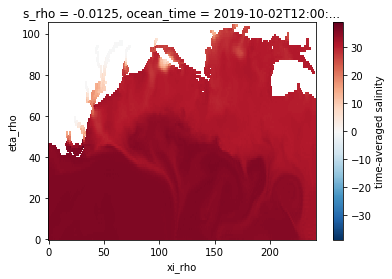

In [6]:
# just want to look at the grid in its _rho coords
plt.figure()
ds.salt.sel(s_rho=0, method='nearest').plot()

# plot a vertical slice

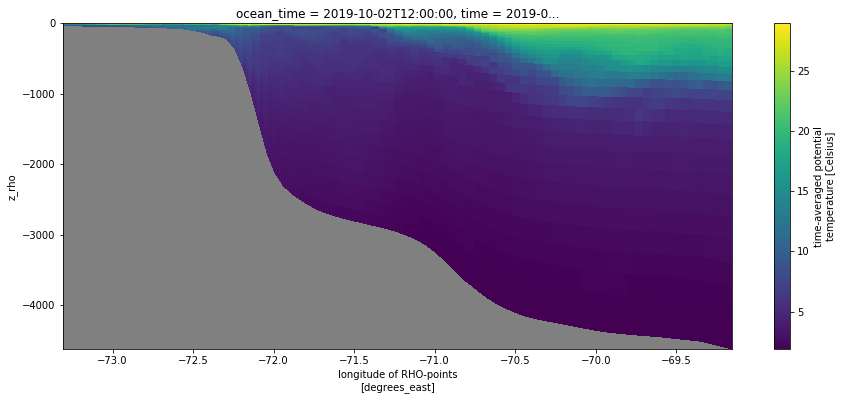

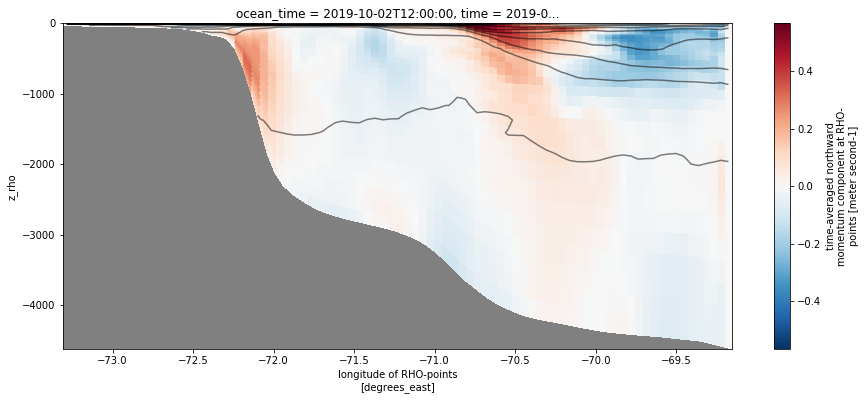

In [7]:
section = ds.isel(xi_rho=100, eta_rho=slice(0, 85)) # can't go into the nan coords (ie on land) and have the plot work...

pres = sw.pres(section.z_rho, section.lat_rho)

rho = sw.pden(section.salt, section.temp, pres)

LON = np.tile(section.lon_rho,(section.z_rho.shape[0],1))



section.temp.plot(x='lon_rho', y='z_rho', figsize=(15, 6))
plt.gca().set_facecolor('gray')


section.v_northward.plot(x='lon_rho', y='z_rho', figsize=(15, 6))
plt.contour(LON, section.z_rho, rho, 20, colors='k', alpha=0.5)
plt.gca().set_facecolor('gray')

# what about the horizontal grid?

Following the nice discussion between Veronica Ruiz Xomchuk, Ryan Abernathey, & Julius Busecke here: https://github.com/xgcm/xgcm/issues/108. Thanks!

we need to remove redundant dims and use xgcm

In [8]:
def rename_redundant_dim(ds, rename_dict):
    for k,v in rename_dict.items():
        ds_full = ds.copy()
        # remove redundant dims
        drop_vars = [a for a in ds.keys() if k in ds[a].dims]
        ds = ds.drop(drop_vars)
        for d in ds_full.data_vars:
            if k in ds_full[d].dims:
                ds[d] = ds_full[d].rename({k:v})
        for c in ds_full.coords:
            if k in ds_full[c].dims:
                ds.coords[c] = ds_full[c].rename({k:v})
    return ds

model_renamed = rename_redundant_dim(ds, {'eta_u':'eta_rho', 'xi_v':'xi_rho'})
model_renamed.pm

<xarray.DataArray 'pm' (eta_rho: 106, xi_rho: 242)>
array([[0.000142, 0.000142, 0.000142, ..., 0.000143, 0.000143, 0.000143],
       [0.000142, 0.000142, 0.000142, ..., 0.000143, 0.000143, 0.000143],
       [0.000142, 0.000142, 0.000142, ..., 0.000143, 0.000143, 0.000143],
       ...,
       [0.000142, 0.000142, 0.000142, ..., 0.000145, 0.000145, 0.000145],
       [0.000142, 0.000142, 0.000142, ..., 0.000145, 0.000145, 0.000145],
       [0.000142, 0.000142, 0.000142, ..., 0.000145, 0.000145, 0.000145]])
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 -75.19 -75.13 -75.08 ... -64.62 -64.54
    lat_rho     (eta_rho, xi_rho) float64 32.24 32.28 32.32 ... 46.58 46.61
    ocean_time  datetime64[ns] 2019-10-02T12:00:00
    time        datetime64[ns] 2019-07-21T12:00:00
    time_run    datetime64[ns] 2019-07-20T12:00:00
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    units:        meter-1
    long_name:    curvilinear coordinate metric in XI
    grid:         grid
    l

In [9]:
from xgcm import Grid

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        's':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(model_renamed, coords=coords)

grid

<xgcm.Grid>
X Axis (periodic):
  * center   xi_rho --> inner
  * inner    xi_u --> center
Y Axis (periodic):
  * center   eta_rho --> inner
  * inner    eta_v --> center
s Axis (periodic):
  * center   s_rho --> outer
  * outer    s_w --> center

In [12]:
# why is the diff not shifting to the rho point? because I'm diffing the other component that is on the oposite edge?
# U is is on eta_rho, so if you diff, it goes to eta_v? and its non-diff dim is xi_u. the opposite happens to Vx
# so to fix this do we interp onto rho? can you do 2d interp?

u_2d = model_renamed.isel( s_rho=-1).u[:,:]
v_2d = model_renamed.isel( s_rho=-1).v[:,:]

# # dudx = grid.diff(u_2d, 'xi')* model_renamed.pm
# # dvdy = grid.diff(v_2d, 'eta')* model_renamed.pn


# dvdx = grid.diff(v_2d, 'xi')* model_renamed.pm
# dudy = grid.diff(u_2d, 'eta')* model_renamed.pn




# vort

dvdx = grid.diff(v_2d, 'X')
print(dvdx)

dudy = grid.diff(u_2d, 'Y')
dudy
# dvdy = grid.diff(v_2d, 'eta')
# dvdy


vort = dvdx - dudy 
dvdx

<xarray.DataArray (eta_v: 105, xi_u: 241)>
array([[ 0.041059, -0.172794,  0.09198 , ...,  0.070667,  0.049902,  0.009505],
       [ 0.340619, -0.271663, -0.082635, ...,  0.022753,  0.070781, -0.026042],
       [ 0.079701, -0.279771, -0.145975, ...,  0.03064 ,  0.104319,  0.066812],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Dimensions without coordinates: eta_v, xi_u


<xarray.DataArray (eta_v: 105, xi_u: 241)>
array([[ 0.041059, -0.172794,  0.09198 , ...,  0.070667,  0.049902,  0.009505],
       [ 0.340619, -0.271663, -0.082635, ...,  0.022753,  0.070781, -0.026042],
       [ 0.079701, -0.279771, -0.145975, ...,  0.03064 ,  0.104319,  0.066812],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Dimensions without coordinates: eta_v, xi_u

# psi coords
These seem to match the velocity edges where vorticity would be computed

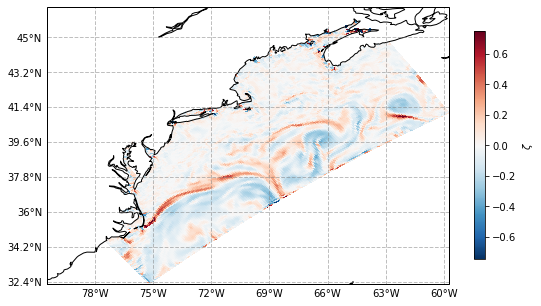

In [25]:
# import cartopy.crs as ccrs
# import cartopy
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

gl = ax.gridlines(draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


cc = ax.pcolor(ds.lon_psi, ds.lat_psi, vort, cmap='RdBu_r', vmin=-.75, vmax=.75, transform=ccrs.PlateCarree())
plt.colorbar(cc, shrink=0.7, label='$\zeta$')

In [93]:
model_renamed.pm

<xarray.DataArray 'pm' (eta_rho: 106, xi_rho: 242)>
array([[0.000142, 0.000142, 0.000142, ..., 0.000143, 0.000143, 0.000143],
       [0.000142, 0.000142, 0.000142, ..., 0.000143, 0.000143, 0.000143],
       [0.000142, 0.000142, 0.000142, ..., 0.000143, 0.000143, 0.000143],
       ...,
       [0.000142, 0.000142, 0.000142, ..., 0.000145, 0.000145, 0.000145],
       [0.000142, 0.000142, 0.000142, ..., 0.000145, 0.000145, 0.000145],
       [0.000142, 0.000142, 0.000142, ..., 0.000145, 0.000145, 0.000145]])
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 -75.19 -75.13 -75.08 ... -64.62 -64.54
    lat_rho     (eta_rho, xi_rho) float64 32.24 32.28 32.32 ... 46.58 46.61
    ocean_time  datetime64[ns] 2019-10-02T12:00:00
    time        datetime64[ns] 2019-07-21T12:00:00
    time_run    datetime64[ns] 2019-07-20T12:00:00
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    units:        meter-1
    long_name:    curvilinear coordinate metric in XI
    grid:         grid
    l

In [97]:
grid.diff(u_2d, 'Y')

<xarray.DataArray (eta_v: 105, xi_u: 241)>
array([[ 0.02758 , -0.135426, -0.020632, ...,  0.002776, -0.024135, -0.011682],
       [-0.004729,  0.068065,  0.08025 , ...,  0.113468,  0.125151,  0.10223 ],
       [ 0.105295,  0.111389,  0.055493, ...,  0.03559 ,  0.044928,  0.058762],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Dimensions without coordinates: eta_v, xi_u